# Changes

Updated batchnorm weight init to be uniform as well (and not normal).

Increased epochs to 100.

`lowered to 0.11 loss`

Updated to use BCEDiceLoss, which lowers loss.

`lowered loss to 0.066`

Added batchnorm to up blocks.

`lowered loss to 0.065`

Added batchnorm to final block.

`slightly lower to 0.0650`

Increased Image size to 256, decreased batch size to 32.

`lowered to 0.059`

# Setup

In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils import data

from torch.autograd import Variable, Function

from torchvision.datasets import ImageFolder
from torchvision import transforms, datasets

from PIL import Image
import numpy as np
import pandas as pd
from skimage.morphology import label
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})

# Constants

In [3]:
BATCH_SIZE = 32
IMG_PATH = '/home/yvan/projects/data_sci_bowl_2018/data'
N_EPOCHS = 100
FILTER_DEPTH = 1
LR = 0.001

# Data Processing

In [4]:
#create a custom imageloader that gets the name of the file as well
class YvanImageFolder(ImageFolder):
    def __getitem__(self,index):
        return super(YvanImageFolder, self).__getitem__(index), self.imgs[index]

In [4]:
# data process
img_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.Grayscale(),
    transforms.ToTensor(),
])

img_dataset = YvanImageFolder(os.path.join(IMG_PATH, 'train_img'), img_transform)
img_loader = data.DataLoader(dataset=img_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=1)

In [5]:
# mask process
mask_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.Grayscale(),
    transforms.ToTensor(),
])

mask_dataset = YvanImageFolder(os.path.join(IMG_PATH,'train_mask'),mask_transform)
mask_loader = data.DataLoader(dataset=mask_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              num_workers=1)

In [6]:
for (img, img_name), (mask, mask_name) in zip(img_loader, mask_loader):
    a,b = img[0], mask[0]
    test_img = transforms.ToPILImage()(a[0])
    test_mask = transforms.ToPILImage()(b[0])
    print(a.size(), b.size())
    print(torch.max(a[0]), torch.min(a[0]), torch.max(b[0]), torch.min(b[0]))
    break

torch.Size([32, 1, 256, 256]) torch.Size([32, 1, 256, 256])
0.4156862795352936 0.0 1.0 0.0


In [7]:
# torch.std(torch.cat([x[0][0] for x in mask_loader]))

Ok so we can convert our stuff into tensors and convert them back into images.

# Unet model

referenced: https://github.com/milesial/Pytorch-UNet/blob/master/unet/unet_parts.py

In [6]:
from utils import *
    
### conv building block ###

class conv_block(nn.Module):
    def __init__(self, in_chan, out_chan):
        super(conv_block, self).__init__()
        self.conv = nn.Sequential(
            nn.BatchNorm2d(in_chan),
            nn.Conv2d(in_chan, out_chan, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_chan, out_chan, 3, padding=1),
            nn.ReLU()
        )
        
    def forward(self, x):
        x = self.conv(x)
        return x

### inputs and outputs ###

class in_conv(nn.Module):
    def __init__(self, in_chan, out_chan):
        super(in_conv, self).__init__()
        self.conv = conv_block(in_chan, out_chan)
        
    def forward(self, x):
        x = self.conv(x)
        return x
        
class out_conv(nn.Module):
    def __init__(self, in_chan, out_chan):
        super(out_conv, self).__init__()
        self.bn = nn.BatchNorm2d(in_chan)
        self.conv = nn.Conv2d(in_chan, out_chan, 1)
        self.activation = nn.Sigmoid()
        
    def forward(self, x):
        return self.activation(self.conv(self.bn(x)))
    
### actual con blocks ###

class conv_down(nn.Module):
    def __init__(self, in_chan, out_chan):
        super(conv_down, self).__init__()
        self.pool_conv = nn.Sequential(
            conv_block(in_chan, out_chan),
            nn.MaxPool2d(2)
        )
        
    def forward(self, x):
        x = self.pool_conv(x)
        return x

class conv_up(nn.Module):
    def __init__(self, in_chan, out_chan):
        super(conv_up, self).__init__()
        self.conv_up = nn.ConvTranspose2d(in_chan, out_chan, 2, stride=2)
        self.conv = conv_block(2*out_chan, out_chan)
        self.bn = nn.BatchNorm2d(in_chan)
    
    def forward(self, x1, x2):
        x1 = self.bn(x1)
        x1 = self.conv_up(x1)
        x = torch.cat([x2,x1],dim=1)
        x = self.conv(x)
        return x

class unet1(nn.Module):
    def __init__(self, in_chan, out_chan):
        super(unet1, self).__init__()
        self.inc = in_conv(in_chan, 16)
        self.down1 = conv_down(16, 32)
        self.down2 = conv_down(32, 64)
        self.down3 = conv_down(64, 128)
        self.down4 = conv_down(128, 256)
        self.up1 = conv_up(256, 128)
        self.up2 = conv_up(128, 64)
        self.up3 = conv_up(64, 32)
        self.up4 = conv_up(32, 16)
        self.out = out_conv(16, out_chan)
        
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.out(x)
        return x
    
def weights_init(m):
    if type(m) == nn.Conv2d or type(m) == nn.ConvTranspose2d:
        nn.init.xavier_uniform(m.weight, gain=np.sqrt(2))
        nn.init.constant(m.bias,0.0)
    elif type(m) == nn.BatchNorm2d:
        m.weight.data.uniform_(1.0,0.02)
        m.bias.data.zero_()

creating model with 1943251 params and intial param sum 594.3673200905323
training epoch 10
training epoch 20
training epoch 30
training epoch 40
training epoch 50
training epoch 60
training epoch 70
training epoch 80
training epoch 90
training epoch 100
lowest loss: 0.05893091644559588


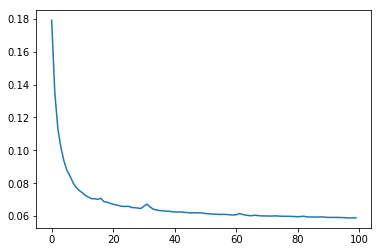

In [9]:
# create a unet
unet = unet1(FILTER_DEPTH, FILTER_DEPTH)
unet.apply(weights_init)
opti = optim.Adam(unet.parameters(), lr=LR, betas=(0.5,0.99))
loss = BCEDiceLoss()

nparams = sum([param.nelement() for param in unet.parameters()])
psum = check_param_sum(unet)
print(f'creating model with {nparams} params and intial param sum {psum}')

if torch.cuda.is_available():
    unet.cuda()
    loss.cuda()

losses = []

for epoch in range(N_EPOCHS):
    epoch_loss = []
    e = epoch+1
    if not e % 10: print(f'training epoch {e}')
    for (batch, batch_name), (mask_batch, mask_name) in zip(img_loader, mask_loader):
        image_batch = to_variable(batch[0])
        labels = to_variable(mask_batch[0])

        x = unet(image_batch)
        l = loss(x, labels)
        epoch_loss.append(l.data[0])
        l.backward()
        opti.step()
        unet.zero_grad()
    losses.append(np.mean(epoch_loss))
    epoch_loss = []

lowestloss = min(losses)
print(f'lowest loss: {lowestloss}')
plt.plot(losses)
plt.show()

In [11]:
# torch.save(unet, 'models/model_feb_feb23-252018.pkl')

/home/yvan/anaconda3/envs/data_sci_bowl_2018/lib/python3.6/site-packages/torch/serialization.py:159: UserWarning: Couldn't retrieve source code for container of type unet1. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/yvan/anaconda3/envs/data_sci_bowl_2018/lib/python3.6/site-packages/torch/serialization.py:159: UserWarning: Couldn't retrieve source code for container of type in_conv. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/yvan/anaconda3/envs/data_sci_bowl_2018/lib/python3.6/site-packages/torch/serialization.py:159: UserWarning: Couldn't retrieve source code for container of type conv_block. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/yvan/anaconda3/envs/data_sci_bowl_2018/lib/python3.6/site-packages/torch/serialization.py:159: UserWarning: Couldn't retrieve source code for container of type co

In [7]:
unet = torch.load('models/model_feb_feb23-252018.pkl')

# Examining Predictions

In [8]:
#make a less memory intensive inference dataloader (small batch size)
BATCH_SIZE_INF = 8
# data process
img_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.Grayscale(),
    transforms.ToTensor(),
])

img_dataset = YvanImageFolder(os.path.join(IMG_PATH, 'train_img'), img_transform)
img_loader = data.DataLoader(dataset=img_dataset,
                             batch_size=BATCH_SIZE_INF,
                             shuffle=False,
                             num_workers=1)


# mask process
mask_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.Grayscale(),
    transforms.ToTensor(),
])

mask_dataset = YvanImageFolder(os.path.join(IMG_PATH,'train_mask'),mask_transform)
mask_loader = data.DataLoader(dataset=mask_dataset,
                              batch_size=BATCH_SIZE_INF,
                              shuffle=False,
                              num_workers=1)

In [9]:
predicted_masks = []
actual_masks = []
names = []
for (batch, batch_name), (mask_batch, mask_name) in zip(img_loader, mask_loader):
    image_batch = to_variable(batch[0])
    labels = to_variable(mask_batch[0])
    names.extend(batch_name[0])
    x = unet(image_batch)
    for i, l in zip(x.data, labels.data):
        predicted_masks.append(transforms.ToPILImage()(i.cpu()))
        actual_masks.append(transforms.ToPILImage()(l.cpu()))
        
assert len(predicted_masks) == len(actual_masks)
assert len(predicted_masks) == len(names)

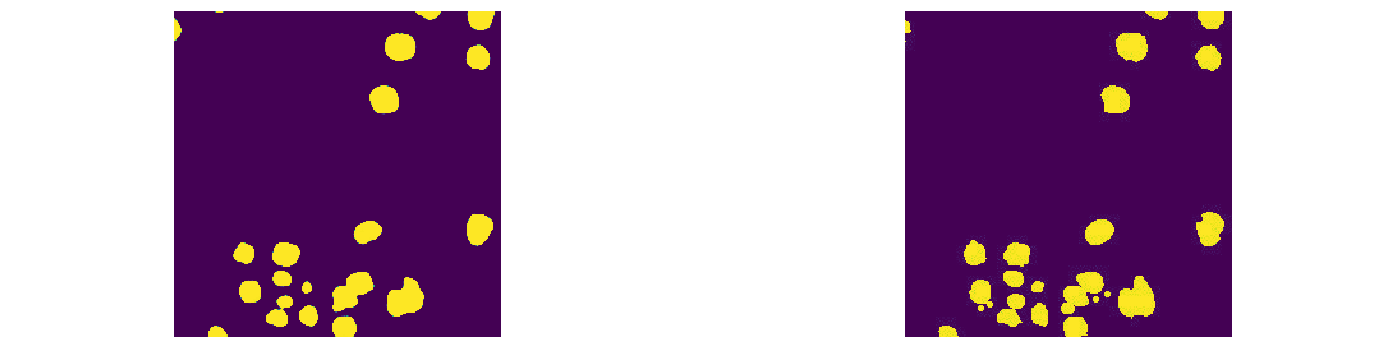

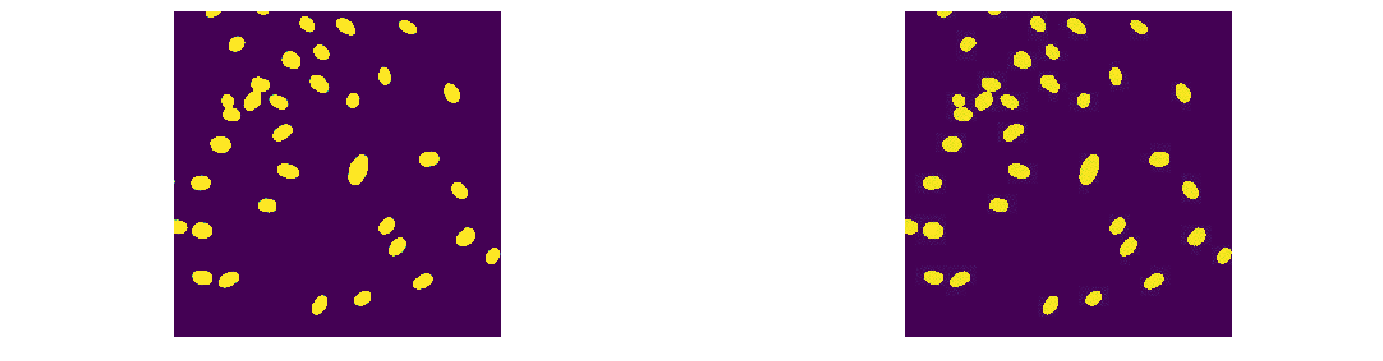

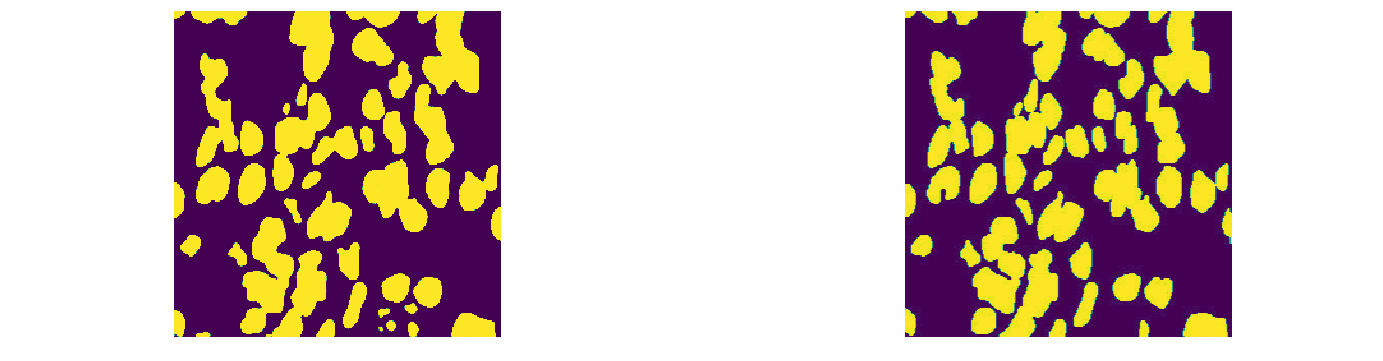

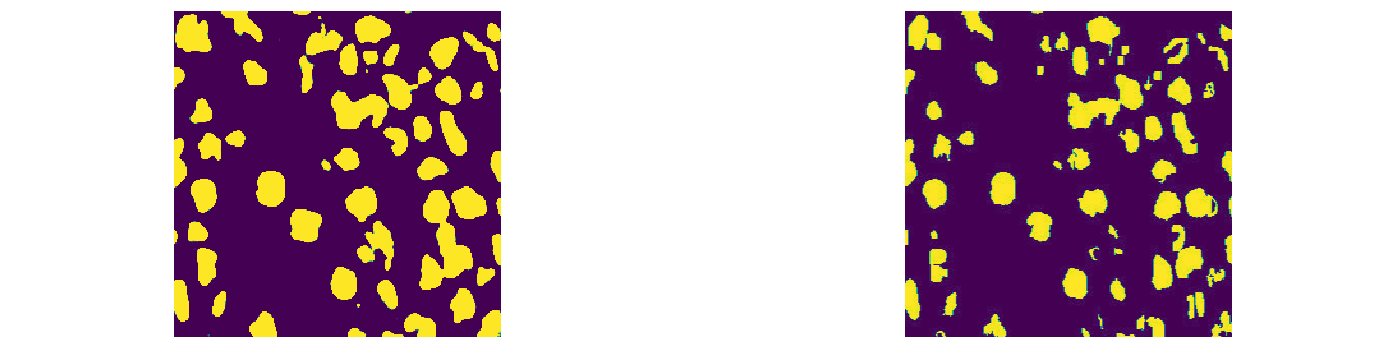

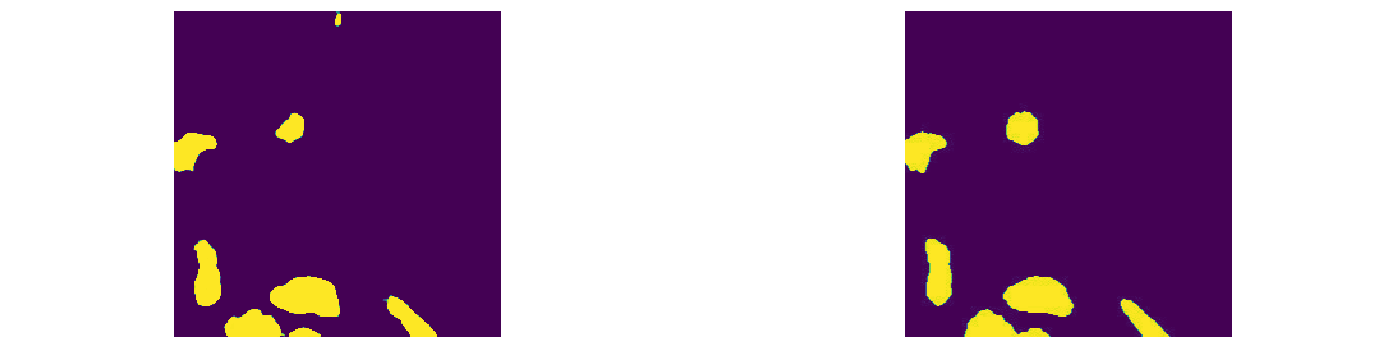

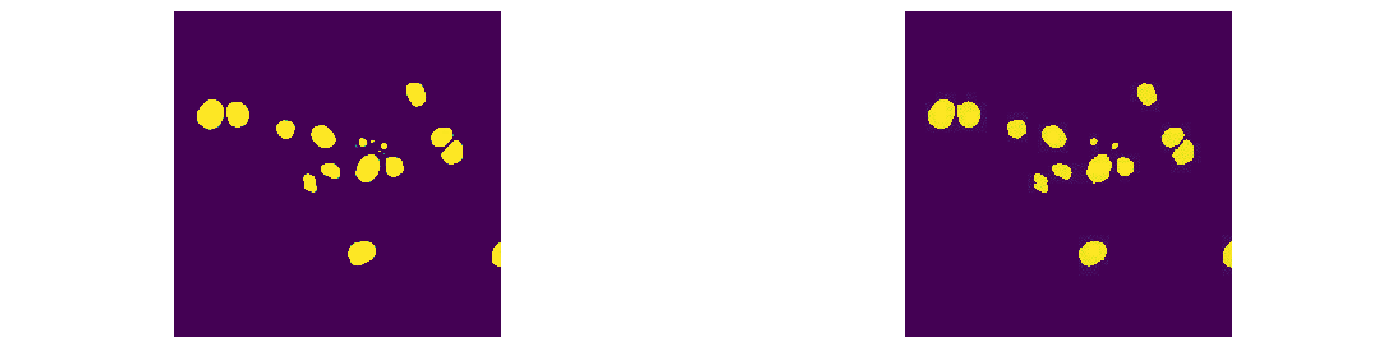

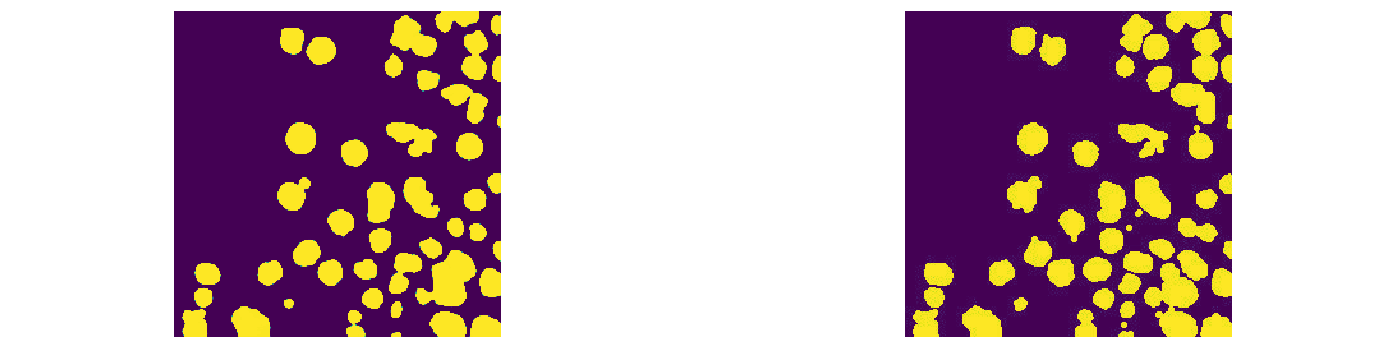

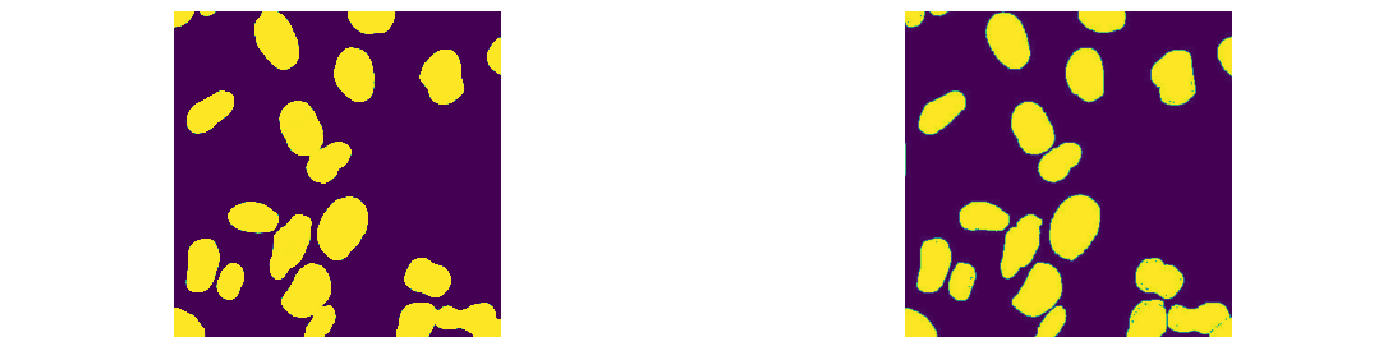

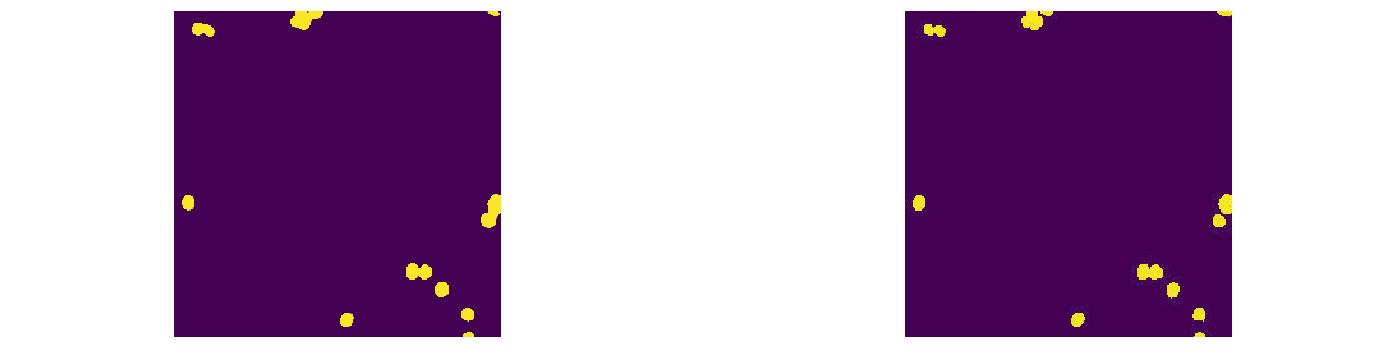

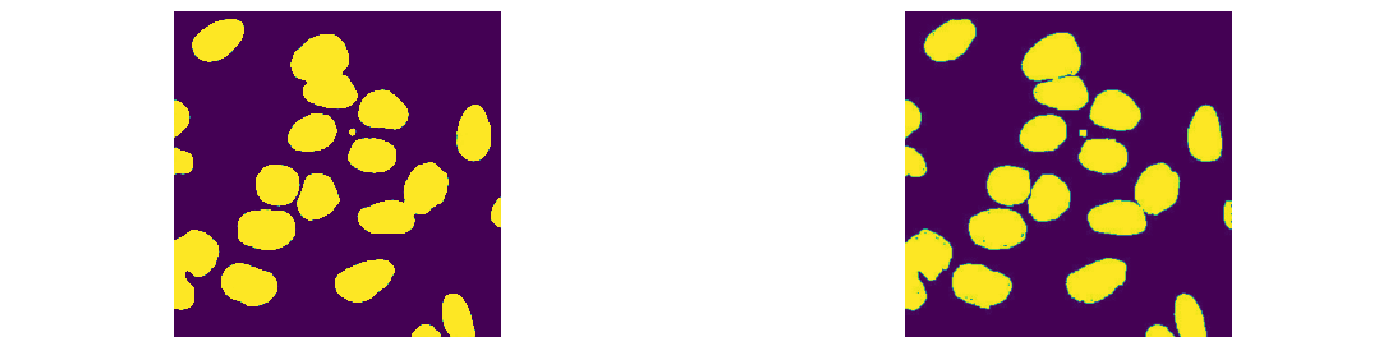

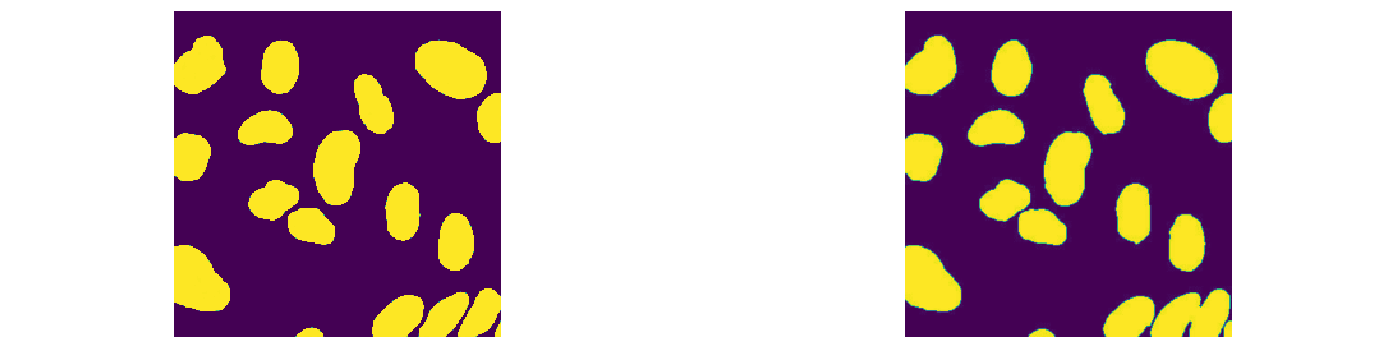

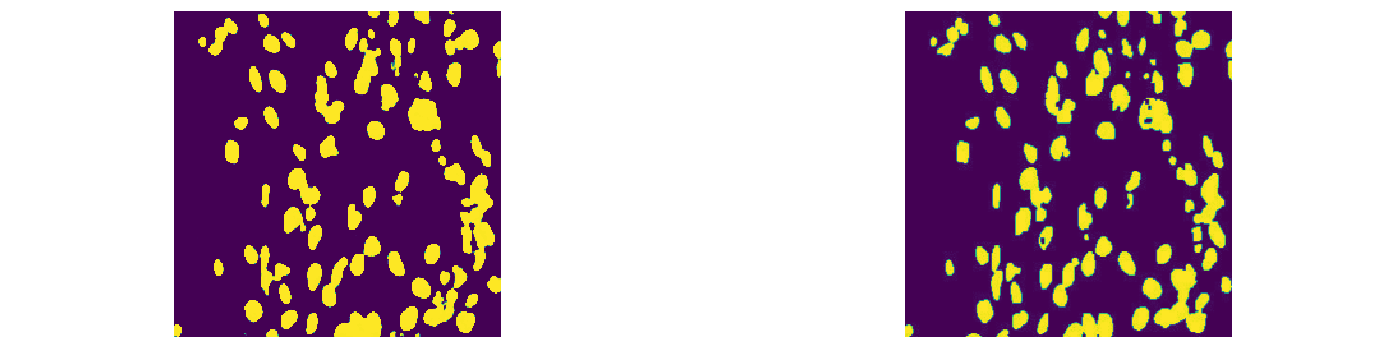

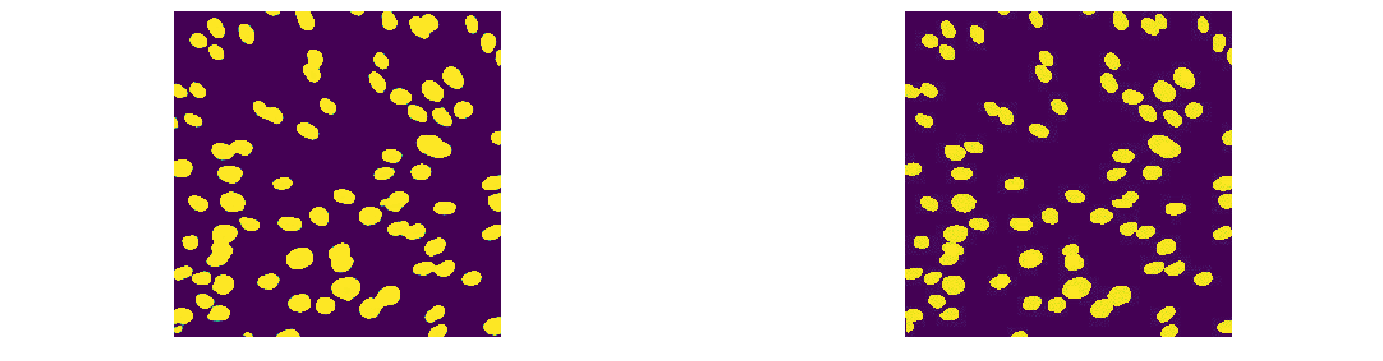

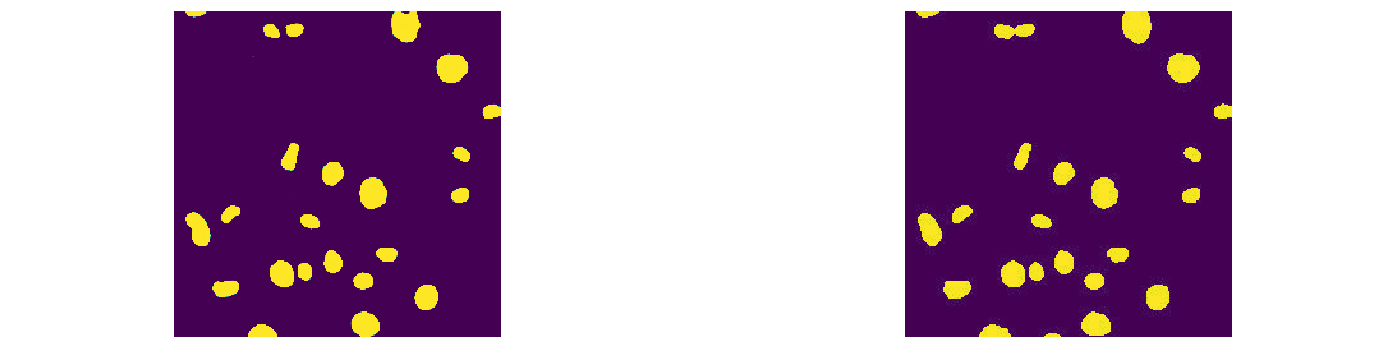

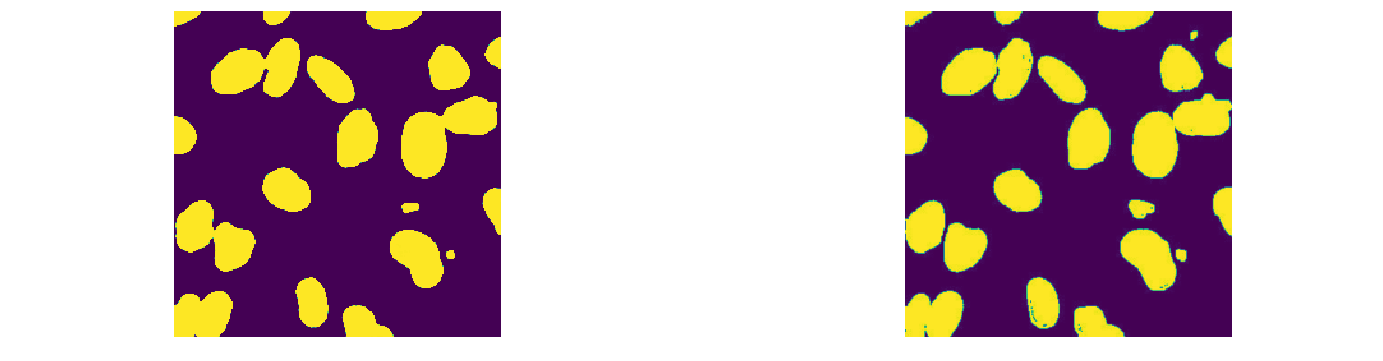

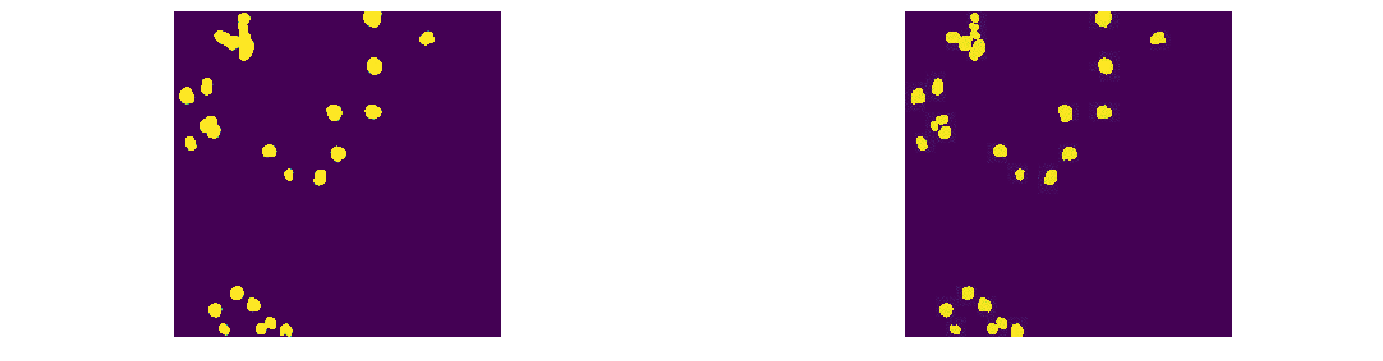

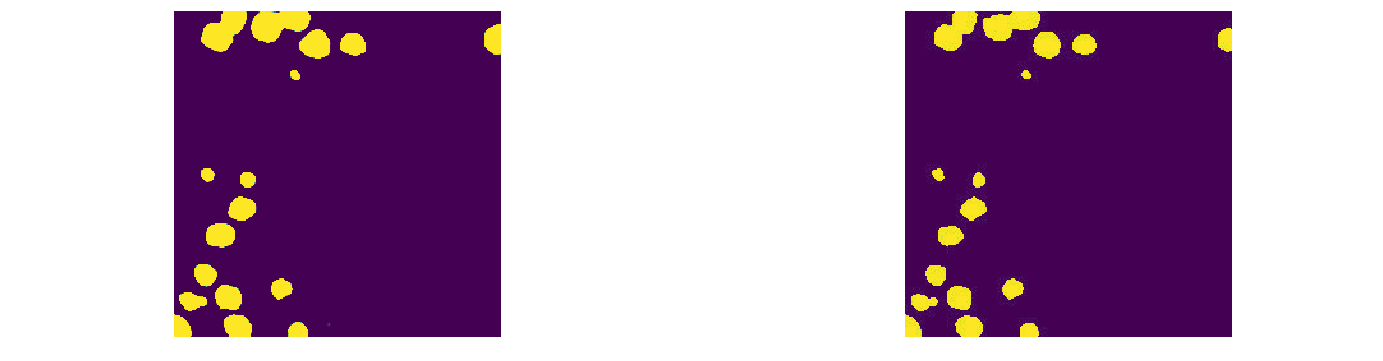

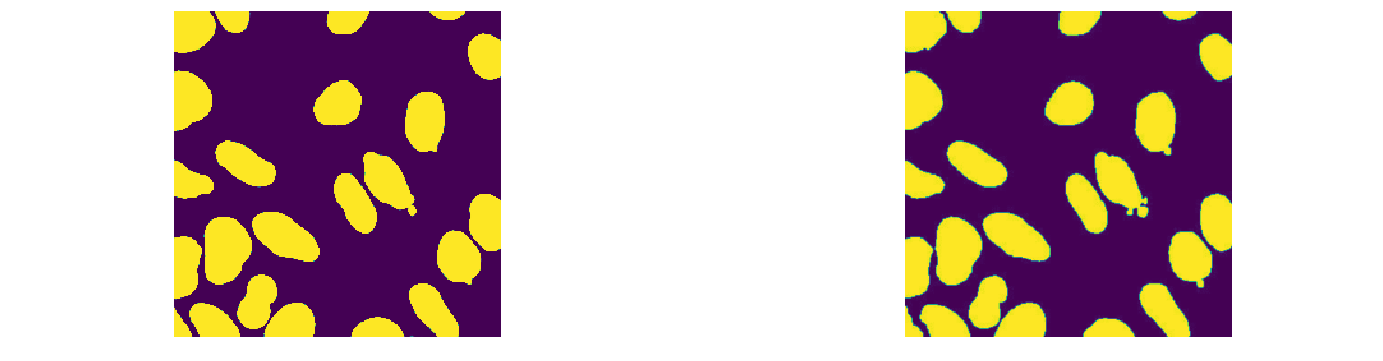

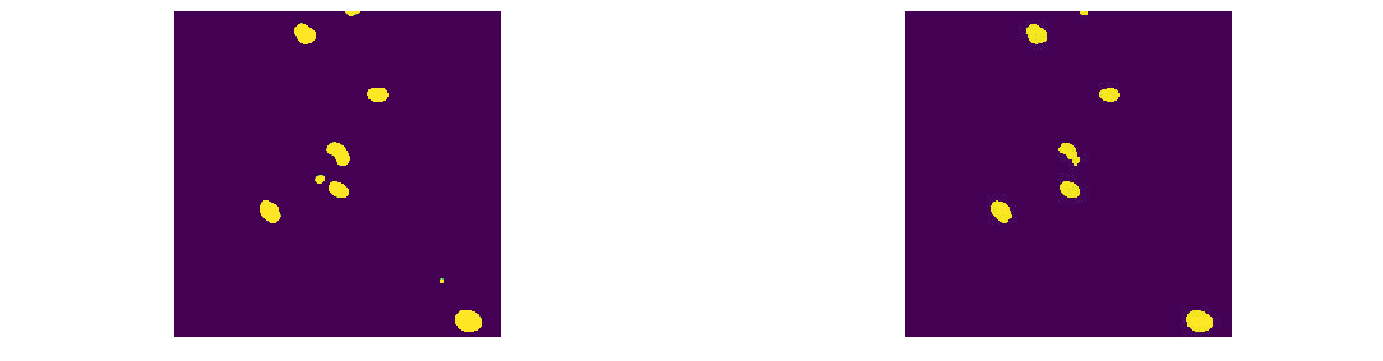

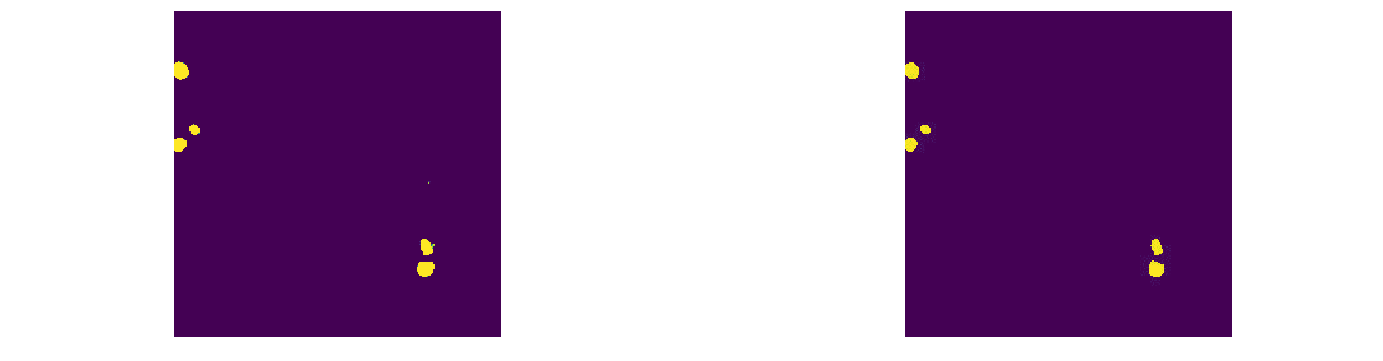

In [10]:
def show_n(img_files, n=6):
    _, ax = plt.subplots(1, n, sharex='col', sharey='row', figsize=(24,6))
    
    for i, img_file in enumerate(img_files):
        ax[i].imshow(img_file)
        ax[i].axis('off')
        
for pred,actual in zip(predicted_masks[:20], actual_masks[:20]):
    show_n([np.asarray(pred), np.asarray(actual)],n=2)

# Generating test predictions

In [11]:
test_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.Grayscale(),
    transforms.ToTensor()
])


test_transform_size = transforms.Compose([
    transforms.ToTensor()
])

test_dataset = YvanImageFolder(os.path.join(IMG_PATH, 'test_img'), test_transform)
test_loader = data.DataLoader(dataset=test_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=1)


test_sizes = YvanImageFolder(os.path.join(IMG_PATH, 'test_img'), test_transform_size)
test_sizes_loader = data.DataLoader(dataset=test_sizes,
                             batch_size=1,
                             shuffle=False,
                             num_workers=1)

In [12]:
sizes_in_order = [tuple(batch[0].size()[2:]) for batch, paths in test_sizes_loader]

In [13]:
predicted_names = []
predicted_test = []
ct = 0

for batch, paths in test_loader:
    predicted_names += list(paths[0])
    image_batch = to_variable(batch[0])
    x = unet(image_batch)
    for i in x.data:
        size = sizes_in_order[ct]
        im = transforms.ToPILImage(mode='L')(i.cpu())
        im = im.resize((size[1], size[0]))
        predicted_test.append(im)
        ct += 1

In [14]:
for i in range(len(sizes_in_order)): 
    assert sizes_in_order[i] == np.asarray(predicted_test[i].convert('1')).shape

# Make a submission

In [15]:
import pandas as pd

def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

test_names = []
test_rles = [] 
for i, (p, path) in enumerate(zip(predicted_test, predicted_names)):
    supposed_size = sizes_in_order[i]
    pred_slide = np.asarray(np.array(p)/255)
    name = os.path.splitext(os.path.basename(path))[0].split('_')[0]
    rles = list(prob_to_rles(pred_slide))
    test_rles.extend(rles)
    test_names.extend([name]*len(rles))

In [16]:
sub = pd.DataFrame()
sub['ImageId'] = test_names
sub['EncodedPixels'] = pd.Series(test_rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.tail(n=15)

,ImageId,EncodedPixels
1548,fe9adb627a6f45747c5a8223b671774791ededf9364f65...,18077 4 18333 4 18587 8 18843 8 19099 2 19105 ...
1549,fe9adb627a6f45747c5a8223b671774791ededf9364f65...,30881 12 31137 12 31391 14 31647 14 31903 14 3...
1550,fe9adb627a6f45747c5a8223b671774791ededf9364f65...,26277 2 26533 2 26785 10 27041 10 27297 10 275...
1551,fe9adb627a6f45747c5a8223b671774791ededf9364f65...,15531 2 15787 2 16041 8 16059 6 16297 8 16315 ...
1552,fe9adb627a6f45747c5a8223b671774791ededf9364f65...,2745 4 3001 4 3255 10 3511 10 3767 12 4023 12 ...
1553,fe9adb627a6f45747c5a8223b671774791ededf9364f65...,25277 8 25533 8 25789 10 26045 10 26301 10 265...
1554,fe9adb627a6f45747c5a8223b671774791ededf9364f65...,30417 6 30673 6 30925 12 31181 12 31435 14 316...
1555,fe9adb627a6f45747c5a8223b671774791ededf9364f65...,15577 8 15833 8 16087 10 16343 10 16597 14 168...
1556,fe9adb627a6f45747c5a8223b671774791ededf9364f65...,41691 6 41947 6 42201 10 42457 10 42713 12 429...
1557,fe9adb627a6f45747c5a8223b671774791ededf9364f65...,21219 8 21475 8 21731 10 21987 10 22243 10 224...


In [17]:
sub.to_csv(os.path.join(IMG_PATH, 'submissions','feb252018_1.csv'), index=False)

Ok all this lowered the LB score ot 0.199 but the data seems pretty well fitted (0.05 much better than the prior notebook's 0.13-0.15). So now well want to add some dropout, validation data, etc. It may be worth trying to fit the data harder but i'm not sure how.